In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk

In [4]:
df_news = pd.read_csv("../data/raw_analyst_ratings.csv")

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [6]:



df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')
df_news = df_news.dropna(subset=['date'])  

df_news['headline_length'] = df_news['headline'].astype(str).apply(len)

df_news['sentiment'] = df_news['headline'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)


Step 2: Plot and EDA Visuals

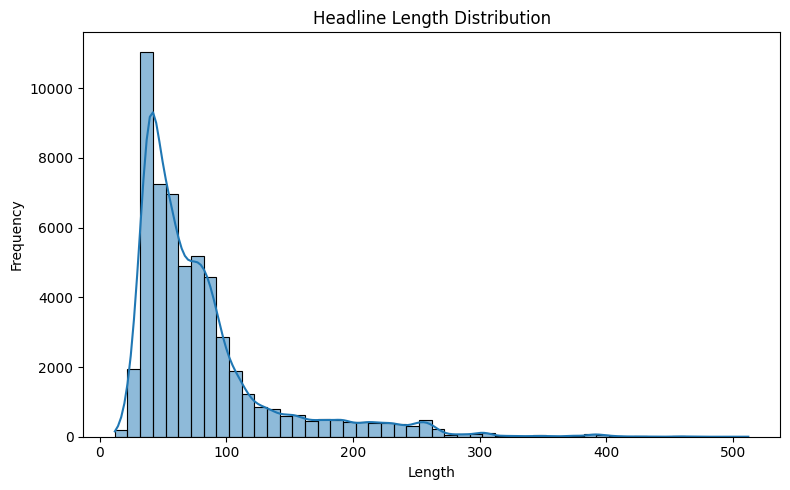

In [8]:
# 1. Headline Length Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_news['headline_length'], bins=50, kde=True)
plt.title("Headline Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../images/headline_length_hist.png")
plt.show()

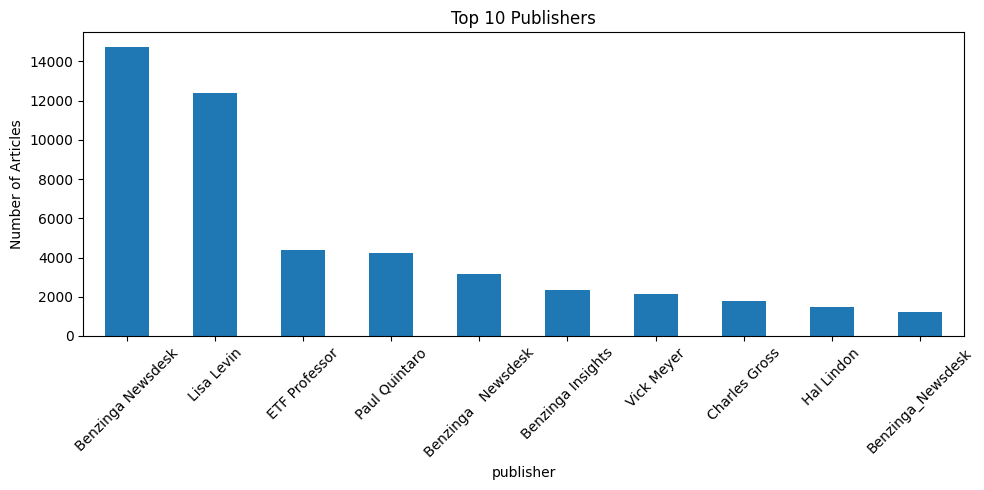

In [9]:
# 2. Top 10 Publishers
plt.figure(figsize=(10,5))
df_news['publisher'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Publishers")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../images/top_publishers_bar.png")
plt.show()

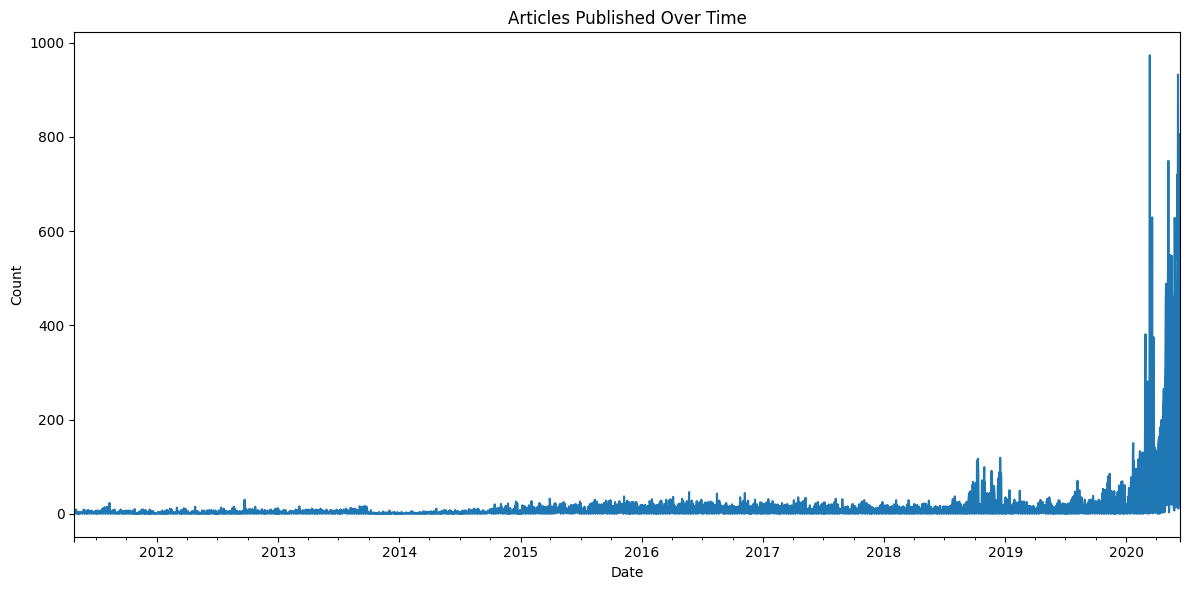

In [10]:
# 3. Articles Published Per Day
articles_per_day = df_news.set_index('date').resample('D').size()
plt.figure(figsize=(12,6))
articles_per_day.plot()
plt.title("Articles Published Over Time")
plt.ylabel("Count")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("../images/articles_over_time_line.png")
plt.show()

In [11]:
# Most Positive Headlines
print("Most Positive Headlines:")
print(df_news[['headline', 'sentiment']].sort_values(by='sentiment', ascending=False).head(5))

# Most Negative Headlines
print("\nMost Negative Headlines:")
print(df_news[['headline', 'sentiment']].sort_values(by='sentiment', ascending=True).head(5))


Most Positive Headlines:
                                                  headline  sentiment
1204942                                5 Best ETFs Of 2019        1.0
339614          Pound Punishment Is Perfect For These ETFs        1.0
145743   The Street Debates Whether Best Buy Investors ...        1.0
1149384                                5 Best ETFs Of 2019        1.0
688090   Jefferies Highlights 5 Best Investment Ideas F...        1.0

Most Negative Headlines:
                                                  headline  sentiment
83634    Mizuho Upgrades Occidental Petroleum, Says Wor...       -1.0
701728   ETFs To Play/Avoid On The Shocking Steve Jobs ...       -1.0
700464   This Hedge Fund Manager's Worst Ideas For 2016...       -1.0
1115337       Worst Performing Industries For June 4, 2015       -1.0
1115333       Worst Performing Industries For July 8, 2015       -1.0
